In [1]:
%matplotlib inline
from __future__ import division
import matplotlib
import numpy as np
from pylab import *
import os
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4)})
plotStyles={"markersize":20,"markeredgewidth":3.0,"linewidth":3.0}
stepStyles={"markersize":20,"markeredgewidth":3.0,"linewidth":3.0,"where":"post"}
np.seterr(divide='ignore',invalid='ignore')
pass

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

# Performance comparison.
Generate the input files and output the commands to run the simulations. Before running, make sure to rename any existing perf.99.latest directory.

In [3]:
%%bash
dirname=data/perf.99.latest
filename=${dirname}/rdme_bimolecular.lm
mkdir -p ${dirname}
rm -f ${filename} && lm_sbml_import ${filename} rdme_bimolecular.sbml > /dev/null
lm_setdm ${filename} numberReactions=2 numberSpecies=3 numberSiteTypes=1 "latticeSize=[5,6,7]" latticeSpacing=1e-6 particlesPerSite=16 "DiffusionMatrix(0,0,:)=[1e-10,1e-10,1e-10]" "ReactionLocationMatrix=[1,1]" > /dev/null
lm_setp ${filename} maxTime=5e2 writeInterval=5e1 latticeWriteInterval=5e1 > /dev/null
echo "Execute the following command in `pwd`:"
echo 'for replicate in `seq -f "%g" 0 10`; do'
echo "echo Running \${replicate};"
#echo "hostname=\`hostname\`"
#echo "lmesPrefix=/share/git/LatticeMicrobesES/build-gpu/"
echo "hostname=barkeri"
#echo "lmesPrefix="
#echo "lmesPrefix=/Users/eroberts/Work/Lab/Git/LatticeMicrobesES-master/build/"
echo "\${lmesPrefix}lmes -r 1-8 -f ${filename} -c 2 -ff null -sl lm::rdme::NextSubvolumeSolver| tee ${filename}.\${hostname}.\${replicate}.log";
#echo "hostname=marcc"
#echo "lmes-submit ${filename} -r 1-15 -c 2 -ff null -sl lm::avx::GillespieDSolverAVX ${filename}.\${hostname}.\${replicate}.log parallel 24 erober32 00:20:00";
echo 'done;'

Execute the following command in /Users/eroberts/Work/Lab/Git/LatticeMicrobesES/regression/rdme_bimolecular:
for replicate in `seq -f "%g" 0 10`; do
echo Running ${replicate};
hostname=barkeri
${lmesPrefix}lmes -r 1-8 -f data/perf.99.latest/rdme_bimolecular.lm -c 2 -ff null -sl lm::rdme::NextSubvolumeSolver| tee data/perf.99.latest/rdme_bimolecular.lm.${hostname}.${replicate}.log
done;


In [14]:
# Extract the timing data.
import re
datadir="data"
timingData={}
testNumberMap={}
regex0 = re.compile("perf\.(\d+).(\S+)")
regex1 = re.compile("\.lm\.([^\.]+)\.(\d+)\.log")
regex2 = re.compile("Finished .+ seconds \((\S+) steps/second\)")
for dirname in os.listdir(datadir):
    testName = None
    m = regex0.search(dirname)
    if m != None:
        testNumber = m.group(1)
        testName = m.group(2)
        testNumberMap[testNumber] = testName
    if testName is not None:
        for logname in os.listdir(datadir+"/"+dirname):
            m = regex1.search(logname)
            if m != None:
                host=m.group(1)
                replicate=int(m.group(2))
                with open(datadir+"/"+dirname+"/"+logname) as f:
                    for line in f:
                        m = regex2.search(line)
                        if m != None:
                            if host not in timingData:
                                timingData[host]={}
                            if testName not in timingData[host]:
                                timingData[host][testName]=[]
                            timingData[host][testName].append(double(m.group(1)))
                            break
print "Finished."

Finished.


In [15]:
print timingData['barkeri']

{'original': [1953000.0, 1956000.0, 1821000.0, 1912000.0, 1905000.0, 1945000.0, 1955000.0, 1893000.0, 1851000.0, 1900000.0, 1805000.0], 'latest': [1897000.0, 1881000.0, 1873000.0, 1903000.0, 1887000.0, 1804000.0, 1894000.0, 1847000.0, 1891000.0, 1860000.0, 1858000.0]}


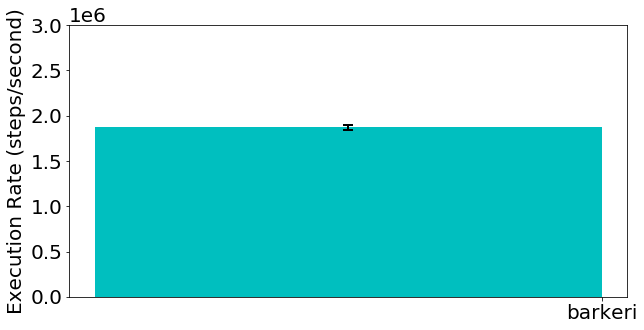

In [17]:
# Plot the latest timing data.
matplotlib.rcParams.update({'font.size': 20, "figure.figsize": (10,5)})
allHosts = timingData.keys()
allHosts.sort()
hosts=[]
times=[]
timesErr=[]
for host in allHosts:
    if "latest" in timingData[host]:
        times.append(mean(timingData[host]['latest']))
        timesErr.append(std(timingData[host]['latest']))
        hosts.append(host)
plt.bar(arange(0,len(hosts))+0.25,times,width=0.5,yerr=timesErr, color='c', error_kw={"elinewidth":2,"capsize":5,"capthick":2})
plt.ylabel('Execution Rate (steps/second)')
plt.xticks(arange(0,len(hosts))+0.5, hosts)
plt.ylim([0,3e6])
pass

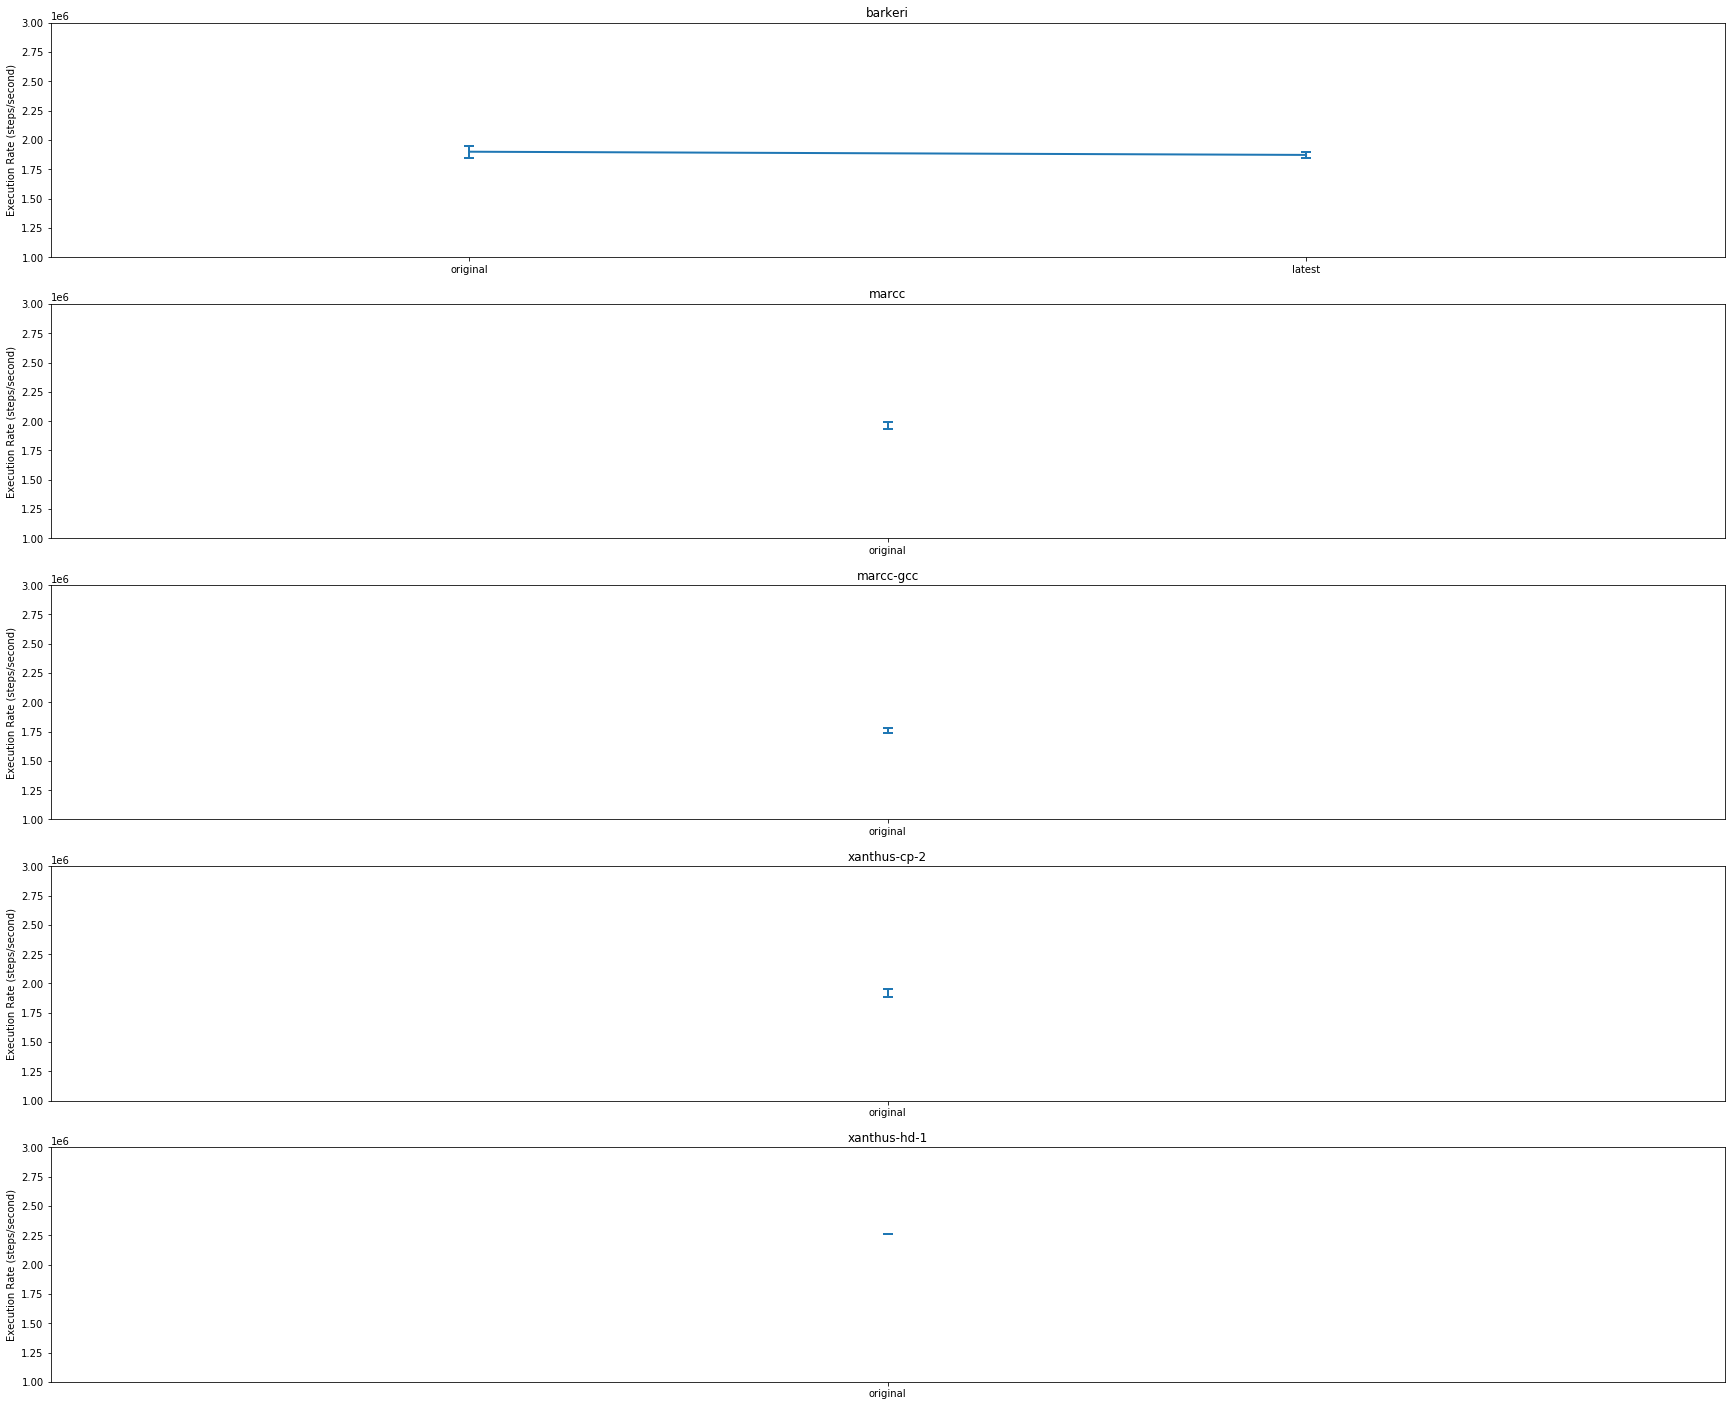

In [18]:
# Plot the previous timing data.
matplotlib.rcParams.update({'font.size': 10, "figure.figsize": (30,25)})
hosts = timingData.keys()
hosts.sort()
testNumbers = testNumberMap.keys()
testNumbers.sort()
for i,host in enumerate(hosts):
    times=[]
    timesErr=[]
    testNames=[]
    for testNumber in testNumbers:
        testName = testNumberMap[testNumber]
        if testName in timingData[host]:
            times.append(mean(timingData[host][testName]))
            timesErr.append(std(timingData[host][testName]))
            testNames.append(testName)
    plt.subplot(len(hosts),1,i+1)
    plt.errorbar(arange(0,len(testNames))+0.5,times,linewidth=2,yerr=timesErr,elinewidth=2,capsize=5,capthick=2)
    plt.ylabel('Execution Rate (steps/second)')
    plt.xticks(arange(0,len(testNames))+0.5, testNames)
    plt.xlim([0,len(testNames)]); plt.ylim([1e6,3e6])
    plt.title(host)
pass